# MIMIC-EYE 1.0 - An Eye-Tracking Data Analytics Toolkit for REFLACX and EYE GAZE

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
import os
import sys
import shutil
import pickle as pkl
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
from mimic.Patient import Patient
from mimic.Xray import Xray
from MIMIC_EYE import MIMIC_EYE 
from Constants import Constants as c
from data.groundtruth.BoundingBox import BoundingBox
from data.groundtruth.Ellipse import Ellipse

from util.mimic_data_processing import *

In [3]:
# starting program
mimic_eye = MIMIC_EYE()

In [4]:
# check if file CACHE_PATH exists
# if it does, load the state
# if it does not, initialize the MIMIC_EYE database
if os.path.exists( c.CACHE_PATH ):
  print("Loading previously saved state...")
  mimic_eye.load_state()
else:
  print("Initializing MIMIC_EYE database...")
  mimic_eye.initialize_mimic_eye()
  mimic_eye.save_state()

Initializing MIMIC_EYE database...


In [5]:
# checking a patient
ref_patient = c.CACHE["PATIENTS"][12629893]
ref_xrays = ref_patient.getXray_lst()
cxr = ref_xrays[0]
cxr.getInfo()

{'ID': 'f0256c5c-a68a55ba-51e7cc78-c6aa82eb-7d0eb5fe',
 'study_id': 's51632471',
 'report': 'FINAL REPORT\nCHEST RADIOGRAPH PERFORMED ON ___\n\nCOMPARISON:  ___.\n\nCLINICAL HISTORY:  Shortness of breath and chest pain.\n\nFINDINGS:  PA and lateral views of the chest were obtained.  Midline\nsternotomy wires and mediastinal clips are again noted. There is a background\nof emphysema better appreciated on the prior radiographs. There has been\ninterval development of pulmonary vascular congestion and mild pulmonary\nedema.  Trace bilateral pleural effusions are present.  No pneumothorax.\nCardiomediastinal silhouette is stable.  Bony structures are intact.\n\nIMPRESSION:  Emphysema with superimposed pulmonary edema.  Trace bilateral\npleural effusions.\n',
 'diagnosis': 'CHF',
 'dicom_path': '/Volumes/SD_DISK/XAMI-MIMICv2.0/patient_12629893/CXR-DICOM/s51632471/f0256c5c-a68a55ba-51e7cc78-c6aa82eb-7d0eb5fe.dcm',
 'jpg_path': '/Volumes/SD_DISK/XAMI-MIMICv2.0/patient_12629893/CXR-JPG/s516324

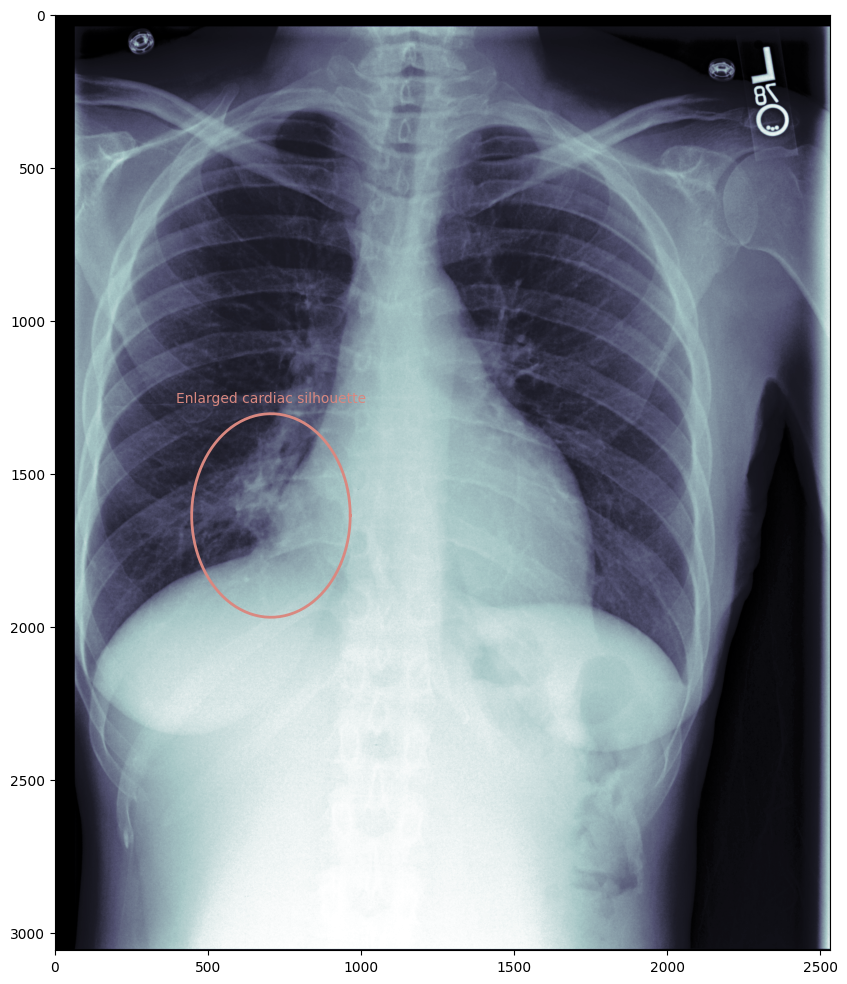

In [7]:
patient2 = c.CACHE["PATIENTS"][c.CACHE['OVERLAP'][0]]
cxr2 = patient2.getXray_lst()[0]
ellipse = cxr2.getAbnormalityDict()["P300R759977"][0]

plt.figure(figsize=(10,15))
ax = plt.axes()

img = plt.imread( cxr2.getJPGPath() )
ax.imshow(img, cmap=plt.cm.bone)  
plt.xlim([0, img.shape[1]])
plt.ylim([0, img.shape[0]])
ax.invert_yaxis()
ellipse.plot_shape(ax, label=True);


In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [9]:
def animate(df, screen_size):
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Set the axis limits based on the screen size
    ax.set_xlim((0, screen_size[0]))
    ax.set_ylim((0, screen_size[1]))
    # Initialize scatter plot with left eye positions
    scat_left = ax.scatter(df['left_eye_x'], df['left_eye_y'], color='blue')
    # Initialize scatter plot with right eye positions
    scat_right = ax.scatter(df['right_eye_x'], df['right_eye_y'], color='red')

In [28]:
c.CACHE["OVERLAP"]

[15857729,
 15752803,
 19157903,
 17023312,
 14492434,
 19565653,
 16831446,
 13977589,
 18087960,
 11004477]

In [9]:
patient = c.CACHE["PATIENTS"][15752803]
cxr = patient.getXray_lst()[0]
cxr.getDICOMPath()

'/Volumes/SD_DISK/XAMI-MIMICv2.0/patient_15752803/CXR-DICOM/s51358448/cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520.dcm'

In [10]:
eye_gaze_sheet =  "/Volumes/SD_DISK/eye_gaze.csv"
gaze_df = pd.read_csv(eye_gaze_sheet)
gaze_df.head()

,SESSION_ID,MEDIA_ID,DICOM_ID,CNT,Time (in secs),TIMETICK(f=10000000),FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,BPOGX,BPOGY,BPOGV,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,RPD,RPS,RPV,BKID,BKDUR,BKPMIN,LPMM,LPMMV,RPMM,RPMMV,SACCADE_MAG,SACCADE_DIR,VID_FRAME,X_ORIGINAL,Y_ORIGINAL
0,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,0,0.00000,6.962092e+11,0.26427,0.18867,0.00000,0.00000,1,0,0.52854,0.37735,1,0.38281,0.59384,17.19830,0.98505,1,0.64184,0.59797,16.76225,0.98505,1,0,0.22803,20,3.36265,1,3.44732,1,0.0,0.0,0,-2,-2
1,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,1,0.01794,6.962093e+11,0.49027,0.37940,0.00000,0.00000,1,0,0.45200,0.38146,1,0.38156,0.59378,17.47636,0.98505,1,0.64049,0.59770,17.21498,0.98505,1,0,0.00000,20,3.49799,1,3.47886,1,0.0,0.0,0,1216,1159
2,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,2,0.02826,6.962094e+11,0.47102,0.37907,0.00000,0.00000,1,0,0.45178,0.37874,1,0.38054,0.59316,16.56400,0.98505,1,0.63954,0.59721,16.91772,0.99209,1,0,0.00000,20,3.53254,1,3.63720,1,0.0,0.0,0,1105,1158
3,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,3,0.04449,6.962096e+11,0.46275,0.37678,0.00000,0.00000,1,0,0.44619,0.37220,1,0.37976,0.59301,17.02368,0.99209,1,0.63827,0.59704,17.39603,0.99912,1,0,0.00000,20,3.49934,1,3.53357,1,0.0,0.0,0,1058,1151
4,1,0,1a3f39ce-ebe90275-9a66145a-af03360e-ee3b163b,4,0.06177,6.962098e+11,0.46065,0.36778,0.01794,0.04382,2,1,0.45437,0.34077,1,0.37967,0.59296,16.84176,0.99912,1,0.63828,0.59696,17.44879,1.00616,1,0,0.00000,20,3.51164,1,3.50221,1,0.0,0.0,0,1046,1123


In [11]:
c.CACHE["XRAY_TO_PATIENT"]["cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520"]

In [12]:

reading = gaze_df[ gaze_df["DICOM_ID"] == "cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520"]
reading.head()

,SESSION_ID,MEDIA_ID,DICOM_ID,CNT,Time (in secs),TIMETICK(f=10000000),FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,BPOGX,BPOGY,BPOGV,LPCX,LPCY,LPD,LPS,LPV,RPCX,RPCY,RPD,RPS,RPV,BKID,BKDUR,BKPMIN,LPMM,LPMMV,RPMM,RPMMV,SACCADE_MAG,SACCADE_DIR,VID_FRAME,X_ORIGINAL,Y_ORIGINAL
290480,9,21,cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520,0,0.00000,1.583146e+11,0.51733,0.74303,0.0,0.00000,1,1,0.51855,0.73775,1,0.29733,0.37671,13.82296,0.95319,1,0.57497,0.40034,13.25115,0.94719,1,0,0.0,23,2.68720,1,2.59338,1,0.00000,0.00000,0,1371,2270
290481,9,21,cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520,1,0.01459,1.583148e+11,0.51591,0.73874,0.0,0.01459,1,1,0.48196,0.63574,1,0.29691,0.37573,14.48894,0.94105,1,0.57446,0.39935,13.59193,0.93504,1,0,0.0,23,2.61344,1,2.66795,1,0.00000,0.00000,0,1363,2257
290482,9,21,cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520,2,0.03101,1.583150e+11,0.51462,0.73483,0.0,0.03100,1,1,0.48223,0.63721,1,0.29688,0.37359,14.18720,0.93504,1,0.57399,0.39682,13.24977,0.93504,1,0,0.0,23,3.13136,1,2.98820,1,10.43903,119.29018,0,1355,2245
290483,9,21,cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520,3,0.04871,1.583151e+11,0.50638,0.70124,0.0,0.03100,1,0,0.45637,0.49058,1,0.29641,0.37152,14.90897,0.94118,1,0.57315,0.39491,13.95523,0.94719,1,0,0.0,23,2.86778,1,2.72975,1,0.00000,0.00000,0,1308,2142
290484,9,21,cb1f25ef-87f09c2a-0f656ffe-f63022ab-8b305520,4,0.06250,1.583153e+11,0.47647,0.55876,0.0,0.03100,1,0,0.44655,0.41629,1,0.29653,0.37070,14.21903,0.95333,1,0.57327,0.39442,13.50678,0.95933,1,0,0.0,23,2.75265,1,2.57169,1,0.00000,0.00000,0,1137,1707


In [ ]:
from PIL import Image


img = plt.imread( cxr.getJPGPath() )

g = GazeAnalyzer( )
g.draw_raw( reading["X_ORIGINAL"].values, reading["Y_ORIGINAL"].values, imagefile = cxr.getJPGPath() )

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(fig, animate, interval=20, blit=True, save_count=50)


writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)

plt.show()

<IPython.core.display.Javascript object>